In [27]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import re

plt.rcParams["figure.dpi"] = 140  # nicer plots

In [34]:
def load_run(path):
    rows = []
    with open(path, "r") as f:
        data = json.load(f)

    for rec in data:
        base = {
            "record_type": rec.get("record_type"),
            "run_type": rec.get("run_type"),
        }

        if rec["record_type"] == "run_meta":
            base.update({
                "summary_total_runtime_s": rec["summary_total_runtime_s"],
                "summary_avg_per_question_s": rec["summary_avg_per_question_s"],
                "summary_questions": rec["summary_questions"],
                "summary_qps": rec["summary_qps"],
                "ingest_time_s": rec["ingest_time_s"],
                "index_build_time_s": rec["index_build_time_s"],
            })
            rows.append(base)

        elif rec["record_type"] == "question_result":
            cb = rec.get("callback_timing", {}) or {}

            base.update({
                "question_number": rec.get("question_number"),
                "question": rec.get("question"),
                "raw_response": rec.get("raw_response"),
                "elapsed_time": rec.get("elapsed_time"),
                "warm_cache_retrieval_time_ms": rec.get("warm_cache_retrieval_time_ms"),

                # timings
                "callback_timing.T_total": cb.get("T_total"),
                "callback_timing.T_retrieve": cb.get("T_retrieve"),
                "callback_timing.T_reason": cb.get("T_reason"),
                "callback_timing.T_generate": cb.get("T_generate"),

                # tokens
                "callback_timing.prompt_tokens": cb.get("prompt_tokens"),
                "callback_timing.completion_tokens": cb.get("completion_tokens"),
                "callback_timing.total_tokens": cb.get("total_tokens"),

                # cache stats
                "callback_timing.cache_hits": cb.get("cache_hits"),
                "callback_timing.cache_misses": cb.get("cache_misses"),
            })
            rows.append(base)

    return pd.DataFrame(rows)

df_base = load_run("agent_results_baseline.json")
df_opt  = load_run("agent_results_optimized.json")
df_all  = pd.concat([df_base, df_opt], ignore_index=True)
df_all


,record_type,run_type,summary_total_runtime_s,summary_avg_per_question_s,summary_questions,summary_qps,ingest_time_s,index_build_time_s,question_number,question,...,warm_cache_retrieval_time_ms,callback_timing.T_total,callback_timing.T_retrieve,callback_timing.T_reason,callback_timing.T_generate,callback_timing.prompt_tokens,callback_timing.completion_tokens,callback_timing.total_tokens,callback_timing.cache_hits,callback_timing.cache_misses
0,run_meta,baseline,43.531726,14.510575,3.0,0.068915,0.142445,36.330763,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,question_result,baseline,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Report the Gross Margin (%) over the last 5 qu...,...,NaN,19.5751,0.3699,19.1737,17.4812,3762.0,863.0,4625.0,0.0,1.0
2,question_result,baseline,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Show Operating Expenses for the last 3 fiscal ...,...,NaN,10.0427,0.3822,9.6424,6.1331,9150.0,722.0,9872.0,0.0,1.0
3,question_result,baseline,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Calculate the Operating Efficiency Ratio (Opex...,...,NaN,13.5090,0.6394,12.8531,6.9546,8143.0,910.0,9053.0,0.0,1.0
4,run_meta,optimized,33.319774,11.106591,3.0,0.090037,0.138727,38.485296,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,question_result,optimized,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Report the Gross Margin (%) over the last 5 qu...,...,599.782228,10.6723,0.8757,9.7645,7.8900,4794.0,831.0,5625.0,0.0,1.0
6,question_result,optimized,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Show Operating Expenses for the last 3 fiscal ...,...,451.231241,9.7285,0.3605,9.3481,4.7336,9156.0,761.0,9917.0,0.0,1.0
7,question_result,optimized,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Calculate the Operating Efficiency Ratio (Opex...,...,574.627399,10.4139,0.4020,9.9957,5.3859,8143.0,922.0,9065.0,0.0,1.0


In [42]:
latency_table = (
    df_q[
        [
            "run_type",
            "question_number",
            "elapsed_time",
            "callback_timing.T_total",
            "callback_timing.T_retrieve",
            "callback_timing.T_reason",
            "callback_timing.T_generate",
            "callback_timing.prompt_tokens",
            "callback_timing.completion_tokens",
            "callback_timing.total_tokens",
            "callback_timing.cache_hits",
            "callback_timing.cache_misses",
            "warm_cache_retrieval_time_ms",
        ]
    ]
    .sort_values(["run_type","question_number"])
    .reset_index(drop=True)
)

latency_table


,run_type,question_number,elapsed_time,callback_timing.T_total,callback_timing.T_retrieve,callback_timing.T_reason,callback_timing.T_generate,callback_timing.prompt_tokens,callback_timing.completion_tokens,callback_timing.total_tokens,callback_timing.cache_hits,callback_timing.cache_misses,warm_cache_retrieval_time_ms
0,baseline,1.0,19.551476,19.5751,0.3699,19.1737,17.4812,3762.0,863.0,4625.0,0.0,1.0,0.000000
1,baseline,2.0,10.032779,10.0427,0.3822,9.6424,6.1331,9150.0,722.0,9872.0,0.0,1.0,0.000000
2,baseline,3.0,13.499563,13.5090,0.6394,12.8531,6.9546,8143.0,910.0,9053.0,0.0,1.0,0.000000
3,optimized,1.0,10.647843,10.6723,0.8757,9.7645,7.8900,4794.0,831.0,5625.0,1.0,0.0,599.782228
4,optimized,2.0,9.716285,9.7285,0.3605,9.3481,4.7336,9156.0,761.0,9917.0,1.0,0.0,451.231241
5,optimized,3.0,10.399966,10.4139,0.4020,9.9957,5.3859,8143.0,922.0,9065.0,1.0,0.0,574.627399


In [43]:
df_meta = df_all[df_all["record_type"] == "run_meta"].copy()

run_summary_table = (
    df_meta[
        [
            "run_type",
            "summary_total_runtime_s",
            "summary_avg_per_question_s",
            "summary_questions",
            "summary_qps",
            "ingest_time_s",
            "index_build_time_s",
        ]
    ]
    .sort_values("run_type")
    .reset_index(drop=True)
)

run_summary_table

,run_type,summary_total_runtime_s,summary_avg_per_question_s,summary_questions,summary_qps,ingest_time_s,index_build_time_s
0,baseline,43.531726,14.510575,3.0,0.068915,0.142445,36.330763
1,optimized,33.319774,11.106591,3.0,0.090037,0.138727,38.485296


In [44]:
p_stats = (
    df_q.groupby("run_type")["elapsed_time"]
        .agg(p50=lambda s: np.percentile(s,50),
             p95=lambda s: np.percentile(s,95))
        .reset_index()
)
p_stats


,run_type,p50,p95
0,baseline,13.499563,18.946285
1,optimized,10.399966,10.623055


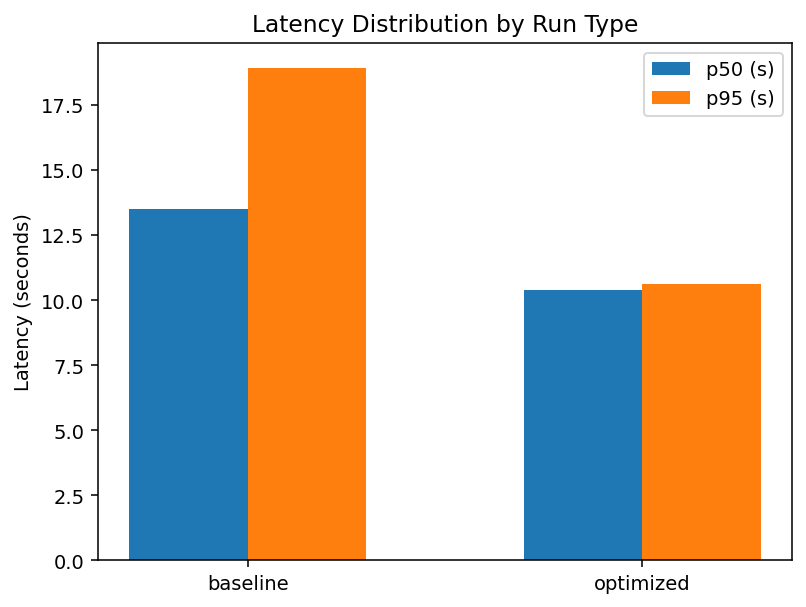

In [45]:
# plot p50 vs p95
fig, ax = plt.subplots()

x = np.arange(len(latency_stats_df))
ax.bar(x - 0.15, latency_stats_df["p50_s"], width=0.3, label="p50 (s)")
ax.bar(x + 0.15, latency_stats_df["p95_s"], width=0.3, label="p95 (s)")

ax.set_xticks(x)
ax.set_xticklabels(latency_stats_df["run_type"])
ax.set_ylabel("Latency (seconds)")
ax.set_title("Latency Distribution by Run Type")
ax.legend()
plt.show()


In [46]:
df_q["is_valid_answer"] = df_q["raw_response"].apply(
    lambda s: 1 if (isinstance(s, str) and len(s.strip()) > 0) else 0
)

acc_pivot = df_q.pivot_table(
    index="question_number",
    columns="run_type",
    values="is_valid_answer",
    aggfunc="max",
    fill_value=0
).sort_index()

acc_pivot


run_type,baseline,optimized
question_number,,
1.0,1,1
2.0,1,1
3.0,1,1
